## Japanese LM

In [54]:
# Your model file (e.g., checkpoint_last.pt) should be placed at the directory, JA_MODEL_PATH.
JA_MODEL_PATH = 'japanese-best-psycho_acc-lm'

In [55]:
import MeCab
import unidic
import unicodedata
import mojimoji
import torch
import sentencepiece as spm
import matplotlib.ticker as plticker
import pandas as pd
import japanize_matplotlib

from torch.nn import CrossEntropyLoss
from fairseq.models.transformer_lm import TransformerLanguageModel
from fairseq.models.lstm_lm import LSTMLanguageModel
from matplotlib import pyplot as plt


def concat_bos(tensor, bos):
    return torch.cat([torch.tensor([bos]), tensor])

# Japanese LM with the best psychometric perdictive power
custom_lm = LSTMLanguageModel.from_pretrained(JA_MODEL_PATH,
                                              'checkpoint_last.pt',
                                              data_name_or_path='japanese-dict',
                                              bpe='sentencepiece',
                                              sentencepiece_model='japanese-dict/spm/japanese_gpt2_unidic.model')

# Japanese LM with the best PPL
# custom_lm = TransformerLanguageModel.from_pretrained(MODEL_PATH,
#                                                      'checkpoint_last.pt',
#                                                      data_name_or_path='japanese-dict',
#                                                      bpe='sentencepiece',
#                                                      sentencepiece_model='japanese-dict/spm/japanese_gpt2_unidic.model')

wakati = MeCab.Tagger('-Owakati -d {}'.format(unidic.DICDIR))
sp = spm.SentencePieceProcessor()
sp.Load("japanese-dict/spm/japanese_gpt2_unidic.model")
loss_fct = CrossEntropyLoss(ignore_index=-1, reduce=False)

sent = "絵文字 (emoji) は世界中で使用されているが、もともとは日本発祥のものである。"
sent = unicodedata.normalize('NFKC', mojimoji.han_to_zen(sent))
sent_wakati = wakati.parse(sent).strip()
pieces = ' '.join(sp.EncodeAsPieces(sent_wakati))

input_ids = custom_lm.binarize(pieces)
bos = custom_lm.src_dict.bos()
input_ids_with_special_token = concat_bos(input_ids, bos)

results = custom_lm.models[0](input_ids_with_special_token.view(1,-1))
surprisals = loss_fct(results[0][0][:-1], input_ids)
surprisals = surprisals.data.tolist()
assert len(surprisals) == len(input_ids)

print('piece: surprisal')
print('\n'.join(f'{custom_lm.src_dict[idx]}: {spr}' for idx, spr in zip(input_ids, surprisals)))

/Users/kuribayashi/Research/ACL2021_final/env_acl2021/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


piece: surprisal
▁絵: 9.536443710327148
▁文字: 8.934932708740234
▁(: 4.174681663513184
▁e: 7.660694122314453
mo: 11.132936477661133
ji: 13.318686485290527
▁): 0.4447309374809265
▁は: 1.759171962738037
▁世界: 6.874046802520752
▁中: 5.832048416137695
▁で: 1.9101715087890625
▁使用: 7.212327480316162
▁さ: 1.2120853662490845
▁れ: 0.30545029044151306
▁て: 0.6821920275688171
▁いる: 0.4405589699745178
▁が: 3.614701271057129
▁、: 0.1880677342414856
▁もともと: 9.00172233581543
▁は: 3.1390433311462402
▁日本: 5.341172695159912
▁発祥: 11.771917343139648
▁の: 1.5449984073638916
▁もの: 5.478940486907959
▁で: 1.5872007608413696
▁ある: 0.7362177968025208
▁。: 0.48289161920547485
</s>: 3.1420812606811523


Text(0.5, 0, 'Pieces')

<Figure size 432x288 with 0 Axes>

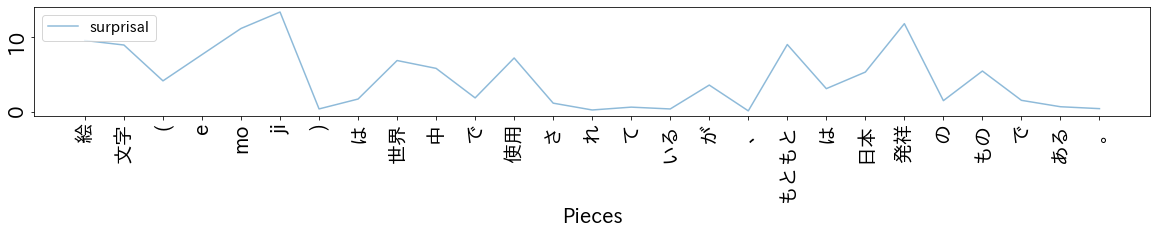

In [56]:
df = pd.DataFrame([[p.strip('▁'), spr] for p, spr in zip(pieces.split(), surprisals)], columns=['piece', 'surprisal'])
plt.figure()
fig, ax = plt.subplots()
loc = plticker.FixedLocator(locs=range(len(df['piece'])))

df[['piece', 'surprisal']].plot(x='piece',figsize=(20,2), ax=ax, alpha=0.5)
ax.tick_params(labelsize=20, labelrotation=90)
ax.xaxis.set_major_locator(loc)
ax.set_xticklabels(df['piece'])
ax.legend(loc=2, prop={'size': 15})
ax.set_xlabel('Pieces',fontsize=20)
# plt.savefig("figure")

In this visualization, surprisals are assigned to each subword unit.  
If you have gold annotation for the phrasal unit (bunsetsu), the surprisals for the same unit should be aggregated (summmed).

## English LM

In [57]:
EN_MODEL_PATH='./english-lm'

In [62]:
english_lm = LSTMLanguageModel.from_pretrained(EN_MODEL_PATH,
                                               'checkpoint_last.pt',
                                                data_name_or_path='english-dict',
                                                bpe='sentencepiece',
                                                sentencepiece_model='english-dict/spm/en_wiki.model')

sp = spm.SentencePieceProcessor()
sp.Load("english-dict/spm/en_wiki.model")
loss_fct = CrossEntropyLoss(ignore_index=-1, reduce=False)

sent = "Emoji is now used all over the world, but originally come from Japan."
pieces = ' '.join(sp.EncodeAsPieces(sent))
input_ids = english_lm.binarize(pieces)
bos = custom_lm.src_dict.bos()
input_ids_with_special_token = concat_bos(input_ids, bos)

results = english_lm.models[0](input_ids_with_special_token.view(1,-1))
surprisals = loss_fct(results[0][0][:-1], input_ids)
surprisals = surprisals.data.tolist()
assert len(surprisals) == len(input_ids)
print('piece: surprisal')
print('\n'.join(f'{english_lm.src_dict[idx]}: {spr}' for idx, spr in zip(input_ids, surprisals)))

piece: surprisal
▁Em: 10.752619743347168
o: 3.4872119426727295
ji: 3.642378091812134
▁is: 4.633724689483643
▁now: 5.215921878814697
▁used: 4.582449913024902
▁all: 9.126615524291992
▁over: 1.3938149213790894
▁the: 0.4488508105278015
▁world: 0.5091878175735474
,: 1.8741304874420166
▁but: 2.294283390045166
▁originally: 9.472311019897461
▁come: 9.134170532226562
▁from: 1.4202744960784912
▁Japan: 3.4479339122772217
.: 0.9546875953674316
</s>: 7.306018352508545


/Users/kuribayashi/Research/ACL2021_final/env_acl2021/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Text(0.5, 0, 'Pieces')

<Figure size 432x288 with 0 Axes>

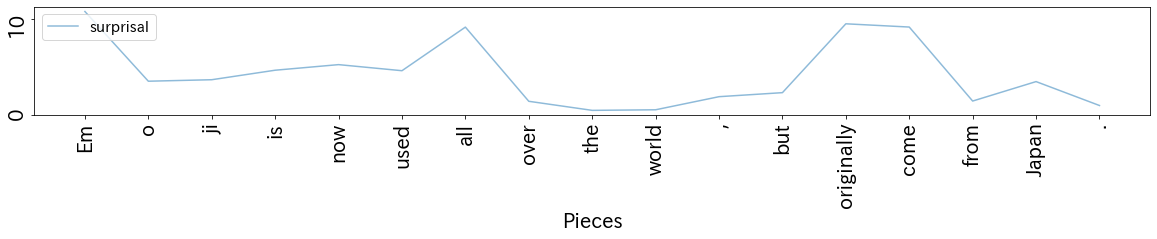

In [63]:
df = pd.DataFrame([[p.strip('▁'), spr] for p, spr in zip(pieces.split(), surprisals)], columns=['piece', 'surprisal'])
plt.figure()
fig, ax = plt.subplots()
loc = plticker.FixedLocator(locs=range(len(df['piece'])))

df[['piece', 'surprisal']].plot(x='piece',figsize=(20,2), ax=ax, alpha=0.5)
ax.tick_params(labelsize=20, labelrotation=90)
ax.xaxis.set_major_locator(loc)
ax.set_xticklabels(df['piece'])
ax.legend(loc=2, prop={'size': 15})
ax.set_xlabel('Pieces',fontsize=20)